02 ビニング、離散化、線形モデル、決定木
================================

* 最良のデータ表現方法は、データの意味だけでなく、利用する機械学習のモデルにも依存する
    
    * 非常に広く利用されている2つのアルゴリズムファミリーは、特徴量の表現の相違に関しては非常に異なる特性を持つ
    
        * 線形モデル
        
        * 決定木ベースのモデル(決定木、勾配ブースティング回帰木、ランダムフォレスト)

* wave回帰データセットに戻ってみる

    * このデータセットには入力特徴量が1つしかない
    
    * 線形回帰モデルと決定木回帰をこのデータセットで比較してみる

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import mglearn
import numpy as np
import matplotlib.pyplot as plt

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


* 線形モデルは線形の関係しかモデリングできない
    
    * 1つしか特徴量がない場合には、1本の線となる

* 決定木ははるかに複雑なモデルを構築することができる

    * しかし、これはデータの表現に大きく依存する
    
* 線形モデルを連続データに対してより強力にする方法の1つとして、特徴量の`ビニング`(`離散化`)がある

    * これは、特徴量を複数の特徴量に分割する方法

### 特徴量のビニング

* 特徴量の入力レンジ(ここでは`-3`から`3`)を固定数の`ビン`(例：10個に分割)することを考える

    * データポイントは、どの`ビン`に分類されたかで表現される
    
    * これにはまず`ビン`を定義しなければならない
    
    * この場合、`-3`から`3`までを等間隔で`10`に区切る
    
    * ここでは`np.linspace`を使って11のエントリを作り、ビンは2つの連続する境界の間に10のビンを作る

In [2]:
bins = np.linspace(-3, 3, 11)
print("bins: {}".format(bins))

bins: [-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]


* 最初のビンには`-3`から`-2.4`までの全ての数が入り、次のビンには`-2.4`から`-1.8`までの数が入る

* 次に、個々のデータポイントがどのビンに入るかを記録する

    * これは、`np.digitize`関数で簡単にできる

In [3]:
which_bin = np.digitize(X, bins=bins)
print("\nData points:\n", X[:5])
print("\nBin membership for data points:\n", which_bin[:5])


Data points:
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]

Bin membership for data points:
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


* ここで行ったのは、waveデータセットの単一の連続値入力特徴量の、どのビンにデータポイントが入っているかを表現したカテゴリ特徴量への置き換え

    * このデータにscikit-learnモデルを適用するには、この離散値特徴量をワンホットエンコーディングに変換する必要がある
    
    * これには、`preprocessing`モジュールの`OneHotEncoder`を用いる
    
     * `OneHotEncoder`は`pandas.get_dummies`と同じ機能を持つが、今のところ整数値で表現されたカテゴリ変数しか扱うことができない

In [4]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoderで変換する
encoder = OneHotEncoder(sparse=False)

# encoder.fitでwhich_binに現れる整数値のバリエーションを確認
encoder.fit(which_bin)

# transformでワンホットエンコーディングを行う
X_binned = encoder.transform(which_bin)
print(X_binned[:5])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


* 10ビンを指定したので、変換されたデータセット`X_binned`には10個の特徴量ができている

In [5]:
print("X_binned.shape: {}".format(X_binned.shape))

X_binned.shape: (120, 10)


* この線形回帰モデルと決定木モデルをこのワンホットエンコーディングデータに対して作り直してみる

    * 結果を以下の図に示す
    
    * ビンの境界もグレーのラインで示してある

Text(0.5, 0, 'Input feature')

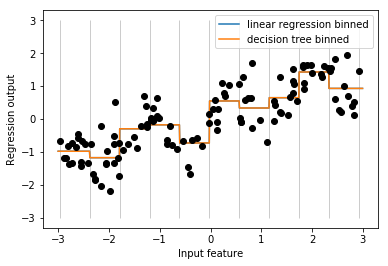

In [10]:
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

* 直線と実線が完全に重なっていて、線形回帰と決定木が完全に同じ予測を行うことがわかる

    * 双方とも、個々のビンに対して一定値を予測する
    
    * ビンごとに特徴量が一定になるので、どのようなモデルを持ってきても、ビンの中では同じ値を予測することになる
    
    * ビニングの前後でモデルが学習したことを比較すると、線形モデルに関してはより柔軟になっているのに対して、決定木に関しては柔軟性が低下している
    
    * 一般に、特徴量をビニングすることは決定木にとってはメリットがない
    
    * もともと決定木は自動的に学習している
    
    * さらに、決定木は複数の特徴量を同時に扱うことができるが、ビニングは1つの特徴量ごとにしか行えない
    
    * 一方で、線形モデルに関してはこの変換による表現力増大の効果は絶大である

* あるデータセットに対してどうしても線形モデルを使いたい場合(例：データがとても大きくて高次元な場合)に、

    * いくつかの特徴量が出力と非線形な関係を持つなら、
    
    * ビニングを使うとモデルの表現力を増強することができる

| 版   | 年/月/日   |
| ---- | ---------- |
| 初版 | 2019/03/18 |